# TSP LP with Pulp

Pulp: https://github.com/coin-or/pulp  
reference: https://nbviewer.jupyter.org/github/cochoa0x1/intro-mathematical-programming/blob/master/05-routes-and-schedules/traveling_salesman.ipynb#

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
seed = 42
np.random.seed(seed=seed)

In [2]:
def gen_param(num):
    path = list(range(num))
    X = np.random.random(num)
    Y = np.random.random(num)
    XY = X + Y * 1j
    return num, path, X, Y, XY

In [3]:
def plot_path(path, edges=False, size=6):
    plt.figure(figsize=(size, size))
    cmap = plt.get_cmap("tab10")
    plt.axis([0,1,0,1], 'equal')
    plt.plot(X[path], Y[path], alpha=0.0)
    plt.scatter(X[0], Y[0], s=80, c='r', marker='o')
    if path:
        for i in range(len(path)-1):
            plt.arrow(X[path[i]], Y[path[i]], 
                      X[path[i+1]]-X[path[i]], Y[path[i+1]]-Y[path[i]], 
                      head_width=0.02, head_length=0.02, length_includes_head=True, 
                      fc=cmap(0), ec=cmap(0))
    if edges:
        for e in edges:
            plt.plot([X[e[0]], X[e[1]]], [Y[e[0]], Y[e[1]]])
    
    for i in range(num):
        plt.text(X[i], Y[i]+0.01, s=i, fontsize=10, color='gray')

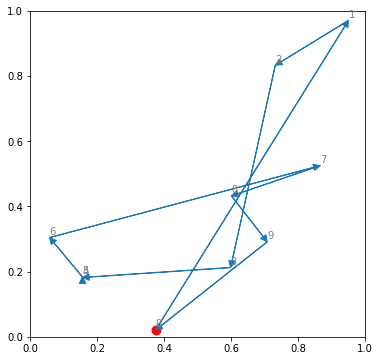

In [4]:
# Generate parameters and Plot initial path
num, path, X, Y, XY = gen_param(10) # the number of nodes
plot_path(path + [0])

## Linear Programming:

In [5]:
# the problem
prob = LpProblem(name='TSP_LP', sense=LpMinimize)

# (i, j) is an edge from node i to node j: distance between i and j
dist = dict({(i, j): (abs(XY[i] - XY[j])) for i in range(num) for j in range(num) if i != j})

#  1: the tour includes an edge from i to j, if not included: 0
x = LpVariable.dicts('x', dist, 0, 1, LpBinary)

# the objective to be minimumized
cost = lpSum([dist[(i,j)] * x[(i,j)] for i, j in dist])
prob += cost

for i in path:
    prob += lpSum([x[(i, j)] for j in path if i != j]) == 1
    prob += lpSum([x[(j, i)] for j in path if i != j]) == 1

# for j in path:
#     prob += lpSum([x[(i, j)] for i in path if i != j]) == 1

In [6]:
# MTZ(Miller-Tucker-Zemlin) Subtour Elimination
u = LpVariable.dicts('u', path, 0, num)
for i in path:
    for j in path:
        if i != j and (i != path[0] and j != path[0]) and (i, j) in x:
            prob += u[i] - u[j] + num * x[(i, j)] <= num - 1

In [7]:
%time prob.solve()  # 20 nodes: 984 ms, 
print(LpStatus[prob.status]) 

CPU times: user 7.42 ms, sys: 966 µs, total: 8.39 ms
Wall time: 651 ms
Optimal


tour         : [0, 4, 5, 6, 8, 2, 1, 7, 9, 3]
tour distance: 2.5362059082065462


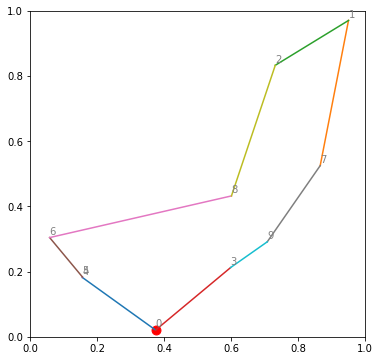

In [8]:
T = [path[0]]
while len(T) < num:
    for key in x:
        if x[key].varValue > 0.99 and key[0] == T[-1]:
            T.append(key[1])

tour_dist = [dist[(T[i - 1], T[i])] for i in range(1, len(T))]

E = []
for key in x:
    if x[key].varValue == 1:
        E.append((key[0], key[1]))

print('tour         :', T)
print('tour distance:', sum(tour_dist))
#print('edges:', E)
plot_path(False, E)

In [240]:
def subtour(x):
    T = [path[0]]
    while True:
        for j in range(num):
            if T[-1] != j and x[(T[-1], j)].varValue > 0.99:
                if j not in T:
                    T.append(j)
                else:
                    return T
Sub = subtour(x)
Sub

[0, 1, 2, 3, 7, 6, 9, 8, 4, 5]

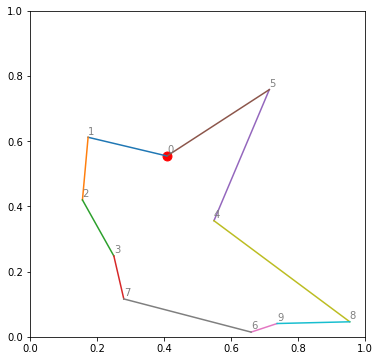

In [234]:
for key in x:
    if x[key].varValue > 0:
        print(key, x[key].varValue)

(0, 1) 1.0
(0, 5) 1.0
(1, 2) 1.0
(2, 3) 1.0
(3, 7) 1.0
(4, 5) 1.0
(4, 7) 1.0
(6, 8) 1.0
(6, 9) 1.0
(8, 9) 1.0


In [228]:
while True:
    if len(Sub) == num:
        print('tour         :', Sub + [path[0]])
        print('tour distance:', sum(tour_dist))
        print('Finish')
        break
    else:
        print('eliminating subtour:', Sub)
        nots = [j for j in range(num) if j not in Sub]
        for j in nots:
            prob += lpSum(x[(i, j)] for i in Sub if i != j) >= 1
        prob.solve()
        

tour         : [0, 1, 2, 3, 7, 6, 9, 8, 4, 5, 0]
tour distance: 2.361875075541071
Finish


In [188]:
print([(i, j) for i in Sub for j in nots if i != j and i != 0 and j != 0])

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8)]


In [12]:
import cv2

k = cv2.waitKey(0)

while True:
    if k == 27:         # wait sfor ESC key to exit
        break
    elif k == ord('s'): # wait for 's' key to save and exit
        break

KeyboardInterrupt: 